# Imports and data
The libraries used in this notebook are available by calling `pipenv install --dev` in the top-level of the repository.
Once installed, you can call `pipenv run jupyter-notebook` to open your Jupyter workspace, navigate to `examples/swifter_speed_comparison.ipynb` and run the cells.

In [4]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import swifter
import perfplot
import matplotlib.pyplot as plt

These data (~71 million rows) were taken from https://www.kaggle.com/benhamner/sf-bay-area-bike-share/data.
In order to run the speed comparisons in this notebook yourself, you will need to download the data from that location, and unzip the file into the the `examples` directory.

In [5]:
data = pd.read_csv('status.csv')
data['date'] = pd.to_datetime(data['time'])

In [6]:
print(data.shape)
data.head()

(71984434, 5)


,station_id,bikes_available,docks_available,time,date
0,2,2,25,2013/08/29 12:06:01,2013-08-29 12:06:01
1,2,2,25,2013/08/29 12:07:01,2013-08-29 12:07:01
2,2,2,25,2013/08/29 12:08:01,2013-08-29 12:08:01
3,2,2,25,2013/08/29 12:09:01,2013-08-29 12:09:01
4,2,2,25,2013/08/29 12:10:01,2013-08-29 12:10:01


# Function Definitions

## Vectorized function
This function doesn't contain any control-flow logic e.g. if/else and is simply a numeric computation.


As such, we can call it in a vectorized fashion e.g. `bikes_proportion(df["bikes_available"], max_x=np.max(data["bikes_available"]))`

In [7]:
def bikes_proportion(x, max_x):
    return x * 1.0 / max_x

## Non-vectorized function
This function does contain a control-flow logic e.g. if/else and therefore cannot be called in a vectorized sense.

As such, we can't include the vectorized comparison in our perfplot.

In [8]:
def is_morning(datetime):
    if (datetime.hour >= 6) and (datetime.hour < 12):
        return True
    else:
        return False

# Perfplot
[Perfplot](https://github.com/unutbu/perfplot) is a library for performing speed comparisons of various functions.

Here we use perfplot to compare pandas apply, dask apply, vectorized functions, and swifter apply.

## Vectorized function speed comparison

In [9]:
vectorized_comparison = perfplot.bench(
    setup=lambda n: data.loc[:n, 'bikes_available'],
    kernels=[
        lambda df: df.apply(bikes_proportion, max_x=np.max(data['bikes_available'])),
        lambda df: dd.from_pandas(df, npartitions=12).map_partitions(bikes_proportion, max_x=np.max(data['bikes_available']), meta=('f8')).compute(scheduler='threads'),
        lambda df: bikes_proportion(df, max_x=np.max(data['bikes_available'])),
        lambda df: df.swifter.progress_bar(False).apply(bikes_proportion, max_x=np.max(data['bikes_available']))
    ],
    labels=['Pandas Apply', 'Dask Apply', 'Vectorized Function', 'Swifter Apply'],
    n_range=[2**k for k in range(10, 28, 2)],
    xlabel='n_rows'
)

100%|██████████| 9/9 [15:03<00:00, 100.35s/it]


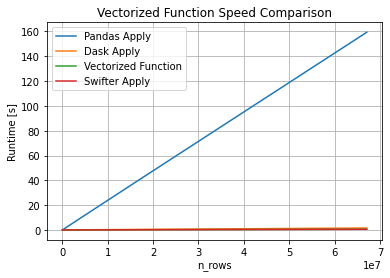

In [10]:
vectorized_comparison.title = "Vectorized Function Speed Comparison"
vectorized_comparison.xlabel = "n_rows"
vectorized_comparison.plot(logx=False, logy=False)

Text(0, 0.5, 'Runtime [log10(s)]')

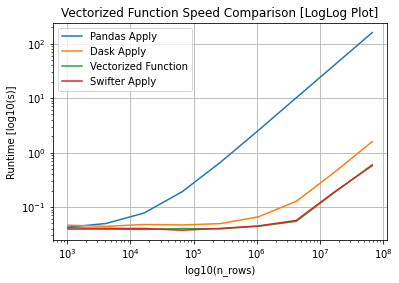

In [11]:
vectorized_comparison.xlabel = 'log10(n_rows)'
vectorized_comparison.title = 'Vectorized Function Speed Comparison [LogLog Plot]'
vectorized_comparison.plot(logx=True, logy=True, time_unit='s')
plt.ylabel("Runtime [log10(s)]")

## Non-vectorized function speed comparison

In [15]:
nonvectorized_comparison = perfplot.bench(
    setup=lambda n: data.loc[:n, 'date'],
    kernels=[
        lambda df: df.apply(is_morning),
        lambda df: dd.from_pandas(df, npartitions=12).apply(is_morning, meta=(bool)).compute(scheduler='threads'),
        lambda df: df.swifter.progress_bar(False).apply(is_morning)
    ],
    labels=['Pandas Apply', 'Dask Apply', 'Swifter Apply'],
    n_range=[2**k for k in range(10, 28, 2)],
    xlabel='n_rows'
)



  0%|          | 0/9 [00:00<?, ?it/s]


  0%|          | 0/3 [00:00<?, ?it/s]


 33%|███▎      | 1/3 [00:00<00:01,  1.13it/s]


 67%|██████▋   | 2/3 [00:01<00:00,  1.11it/s]


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


                                             

 11%|█         | 1/9 [00:02<00:21,  2.71s/it]


  0%|          | 0/3 [00:00<?, ?it/s]


 33%|███▎      | 1/3 [00:00<00:01,  1.04it/s]


 67%|██████▋   | 2/3 [00:01<00:00,  1.03it/s]


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


                                             

 22%|██▏       | 2/9 [00:05<00:19,  2.80s/it]


  0%|          | 0/3 [00:00<?, ?it/s]


 33%|███▎      | 1/3 [00:01<00:02,  1.01s/it]


 67%|██████▋   | 2/3 [00:02<00:01,  1.03s/it]


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


                                             

 33%|███▎      | 3/9 [00:08<00:17,  2.92s/it]


  0%|          | 0/3 [00:00<?, ?it/s]


 33%|███▎      | 1/3 [00:01<00:02,  1.36s/it]


 67%|██████▋   | 2/3 [00:02<00:01

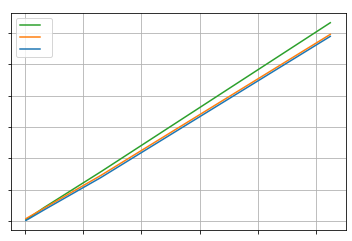

In [16]:
nonvectorized_comparison.title = "Non-Vectorized Function Speed Comparison"
nonvectorized_comparison.xlabel = "n_rows"
nonvectorized_comparison.plot(logx=False, logy=False)

Text(0, 0.5, 'Runtime [log10(s)]')

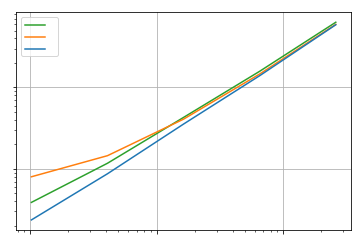

In [17]:
nonvectorized_comparison.xlabel = 'log10(n_rows)'
nonvectorized_comparison.title = 'Non-Vectorized Function Speed Comparison [LogLog Plot]'
nonvectorized_comparison.plot(logx=True, logy=True, time_unit='s')
plt.ylabel("Runtime [log10(s)]")